# BTC_USD Price Direction Prediciton Indicator

In this notebook I am going to try to see if we can find a buying signal using a classifiaction approach to see when the price will go up.

### "The four most dangerous words in investing are: 'This time it's different'."  Sir John Templeton

### 0 - Import Packages


In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_ta as ta
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', 60)


### 1 - Data cleaning and formatting

In [2]:
def fill_gaps_with_forward_filling(df, expected_freq):
    """
    Fills gaps in the DataFrame using forward filling, based on the expected frequency.
    Ensures 'time_period_start' is in datetime format and 'id' is the index.

    Parameters:
        df (pd.DataFrame): The DataFrame to be forward filled.
        expected_freq (str): The frequency string indicating the expected interval between rows.

    Returns:
        pd.DataFrame: The interpolated DataFrame with gaps filled.
    """
    # Ensure 'time_period_start' is in datetime format
    df['time_period_start'] = pd.to_datetime(df['time_period_start'], utc=True)
    
    # Temporarily set 'time_period_start' as the index for interpolation
    df_temp = df.set_index('time_period_start')
    
    # Adjust frequency string to pandas-compatible format
    expected_freq = expected_freq.replace('HRS', 'h').replace('MIN', 'min')
    
    # Generate the complete DateTime index based on the expected frequency
    full_index = pd.date_range(start=df_temp.index.min(), end=df_temp.index.max(), freq=expected_freq)
    
    # Reindex the DataFrame to this full index, introducing NaNs for missing timestamps
    df_reindexed = df_temp.reindex(full_index)

    # Flag rows that are newly introduced by reindexing (contain NaNs)
    df_reindexed['is_interpolated'] = df_reindexed.isna().any(axis=1)
    
    # Perform linear interpolation
    df_forward_filled = df_reindexed.interpolate(method='ffill')
    
    # Move 'time_period_start' back to a column from the index
    df_forward_filled.reset_index(inplace=True)
    df_forward_filled.rename(columns={'index': 'time_period_start'}, inplace=True)

    return df_forward_filled

In [3]:
df = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_15MIN.csv", parse_dates=['time_period_start'])
df = fill_gaps_with_forward_filling(df,'15MIN')
df = df[['time_period_start', 'price_open', 'price_high','price_low', 'price_close', 'volume_traded']].rename(columns={'time_period_start': 'date'})
df['date'] = df['date'].dt.tz_convert(None)
# df.insert(loc=0, column='unique_id', value=1)

print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43488 entries, 0 to 43487
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           43488 non-null  datetime64[ns]
 1   price_open     43488 non-null  float64       
 2   price_high     43488 non-null  float64       
 3   price_low      43488 non-null  float64       
 4   price_close    43488 non-null  float64       
 5   volume_traded  43488 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.0 MB
None


,date,price_open,price_high,price_low,price_close,volume_traded
0,2023-03-01 00:00:00,23144.37,23183.42,23118.58,23163.47,70.088631
1,2023-03-01 00:15:00,23164.60,23221.87,23161.47,23175.01,91.848881
2,2023-03-01 00:30:00,23175.20,23219.56,23145.00,23147.65,78.157423
3,2023-03-01 00:45:00,23149.44,23151.35,23025.17,23103.31,162.990672
4,2023-03-01 01:00:00,23103.30,23169.00,23077.00,23168.42,103.158688
...,...,...,...,...,...,...
43483,2024-05-26 22:45:00,68631.21,68632.02,68526.05,68526.05,40.858640
43484,2024-05-26 23:00:00,68526.06,68536.44,68459.28,68468.49,14.352608
43485,2024-05-26 23:15:00,68465.98,68485.60,68323.29,68380.00,18.821390
43486,2024-05-26 23:30:00,68380.00,68470.35,68307.26,68447.71,32.678318


In [4]:
# Check for missing values
df.isnull().sum()


date             0
price_open       0
price_high       0
price_low        0
price_close      0
volume_traded    0
dtype: int64

### Classification Problem formatting

In [5]:
threshold = 0

# Creating a target that looks 'forward' in time
future_period = 3
df['future_price'] = df['price_close'].shift(-future_period)
df['price_change'] = df['future_price'] - df['price_close']

df['target'] = 0
df.loc[df['price_change'] > threshold, 'target'] += 1

df.dropna(inplace=True)  # Drop rows with NaN values resulting from shifts
df.drop(columns=['price_change', 'future_price'], inplace=True)
df.tail(15)

,date,price_open,price_high,price_low,price_close,volume_traded,target
43470,2024-05-26 19:30:00,68801.98,68855.14,68783.96,68848.81,19.788238,0
43471,2024-05-26 19:45:00,68848.81,68874.47,68801.89,68864.96,11.433655,0
43472,2024-05-26 20:00:00,68866.83,68873.02,68805.06,68806.77,15.426890,0
43473,2024-05-26 20:15:00,68806.77,68814.58,68720.00,68737.49,18.508655,0
43474,2024-05-26 20:30:00,68736.18,68742.63,68660.02,68686.36,24.052207,0
43475,2024-05-26 20:45:00,68686.36,68700.58,68667.31,68680.91,14.446930,0
43476,2024-05-26 21:00:00,68680.91,68680.91,68517.00,68532.73,60.030813,0
43477,2024-05-26 21:15:00,68532.74,68613.17,68532.74,68573.01,18.009711,1
43478,2024-05-26 21:30:00,68573.01,68573.01,68097.38,68353.41,101.128505,1
43479,2024-05-26 21:45:00,68351.50,68510.45,68259.34,68495.63,36.525934,1


### 2 - Exploratory data analysis EDA
Let's explore the distribution of numerical features in more detail, including histograms and kernel density estimations, and box plots. We will:

- Investigate the relationships between numerical features and the target variable (Cover_Type).
- Examine the distribution of categorical features and their impact on the target variable.
- Detect and handle any outliers or anomalies in the dataset.

<Axes: >

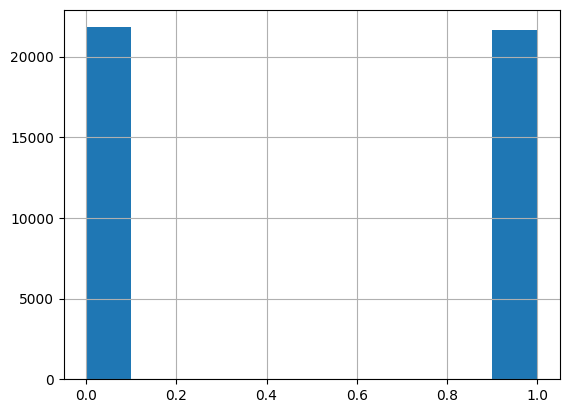

In [6]:
df['target'].hist()

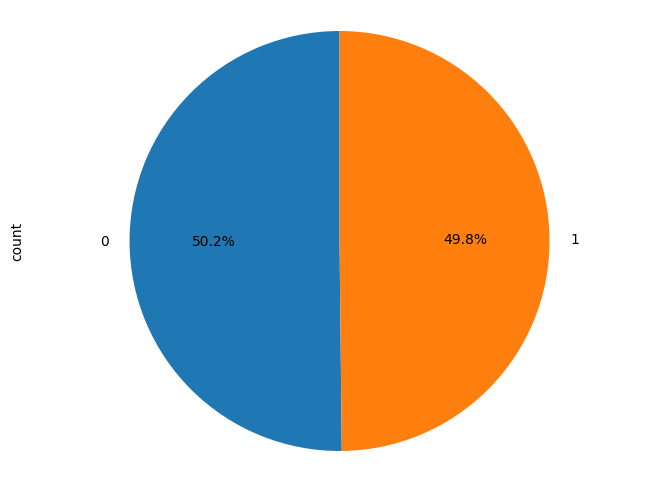

In [8]:
plt.figure(figsize=(8, 6))
df['target'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

No worries about class imbalances during the model training phase.

Distribution of class shows perfect uniform distribution.

#### Distribution and relationship of continuous variables (Elevation, Aspect, Slope, Distance and Hillsahde columns)

In [9]:
'''custom_palette = sns.color_palette("husl", 2) 
print(df.columns)

# Pairplot to visualize relationships between numerical features with custom colors
sns.pairplot(df, hue='target', diag_kind='kde', palette=custom_palette)'''

'custom_palette = sns.color_palette("husl", 2) \nprint(df.columns)\n\n# Pairplot to visualize relationships between numerical features with custom colors\nsns.pairplot(df, hue=\'target\', diag_kind=\'kde\', palette=custom_palette)'

### We defintely need some new feature that exibit specific pattern according to the class because here it is not enough

Text(0.5, 1.0, 'Pearson Correlation of Features')

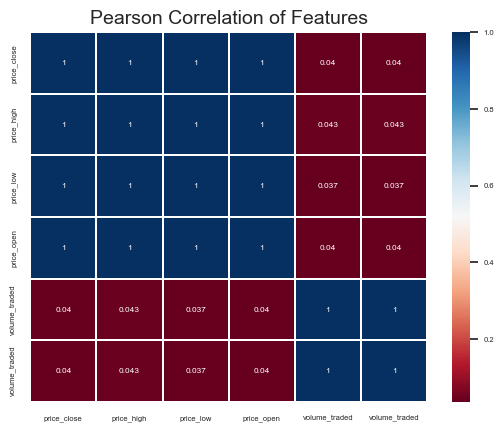

In [10]:

# store continious variables in a list
continuous_variables = ['price_close', 'price_high', 'price_low', 'price_open', 'volume_traded', 'volume_traded']

# make a list of numeric features and create a dataframe with them
train_w_numeric_soil = df[continuous_variables]

# pearson coefficients with numeric soil type column
correlations = pd.DataFrame(train_w_numeric_soil.corr())

figsize=(20,30)
sns.set(font_scale=.5)  # Increase font scale for labels

# plot the heatmap
colormap = plt.cm.RdBu
sns.heatmap(correlations,linewidths=0.1,
            square=False, cmap=colormap, linecolor='white', annot=True)
plt.title('Pearson Correlation of Features', size=14)

### Price Open, Close, Hifh,, Low are correlated at 1 and exibits the same distribution, we will need ther feature

### 3 - Feature Engineering 

In [11]:
init_features = ['price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']
new_features = []

In [12]:
df["price_close_d"] = df["price_close"] * 2
init_features.append('price_close_d')

#### Technical Indicators

Technical indicators were chosen as part of the feature set because they help reduce noise in candlestick data and may reveal price patterns for the model to learn, if any exist. These particular indicators were chosen to give insight into price momentum, volatility, trends, and whether the cryptocurrency is overbought or oversold:

- Rate of Change Ratio (ROCR): Measures the percentage change between the current price and the price a certain number of periods ago.
- Average True Range (ATR): Measures market volatility by analyzing the range of price movement in a given period.
- On-Balance Volume (OBV): Uses volume flow to predict changes in stock price by comparing the volume during uptrends and downtrends.
- Triple Exponential Moving Average (TRIX): Smooths price data and reduces lag by using a triple-smoothed exponential moving average.
- Momentum (MOM): Measures the rate of price change over a specified time period.
- ADX (Average Directional Index): Measures the strength of the trend but not the direction.
- +DI (Positive Directional Indicator, DMP): Measures the presence of an uptrend.
- -DI (Negative Directional Indicator, DMN): Measures the presence of a downtrend.
- Williams %R (WILLR): Indicates whether a security is overbought or oversold by comparing the close price to the high-low range over a certain period.
- Relative Strength Index (RSI): Measures the magnitude of recent price changes to evaluate overbought or oversold conditions.
- Moving Average Convergence Divergence (MACD): Shows the relationship between two moving averages of a security’s price to indicate buy or sell signals.
- Exponential Moving Average (EMA): Gives more weight to recent prices to reduce lag and provide a smoothed price trend.

Note that, in a perfectly efficient market, the future price of a publicly traded asset is not statistically dependent on past prices; the price follows a "random walk," and it's impossible to reliably leverage technical analysis to beat the market. Now, efficient market theory suggests that the U.S. stock market is at least a semi-efficient market, and so we still consider this feature set because many traders utilize technical analysis in their trading strategies and there may exist a relationship between signals from indicators and executed trades, regardless of whether the signals themselves are accurate.

In [13]:
ta_features = []

In [14]:
# Calculate technical indicators

# Rate of Change Ratio
df['ROCR'] = ta.roc(df['price_close'], length=10)  

# Average True Range
df['ATR'] = ta.atr(df['price_high'], df['price_low'], df['price_close'], length=14)  

# On-Balance Volume
df['OBV'] = ta.obv(df['price_close'], df['volume_traded'])  

# Triple Exponential Moving Average
trix = ta.trix(df['price_close'], length=25)  
df['TRIX'] = trix['TRIX_25_9']  

# Momentum
df['MOM'] = ta.mom(df['price_close'], length=10)  

# Average Directional Index
adx = ta.adx(df['price_high'], df['price_low'], df['price_close'], length=14)  
df['ADX'] = adx['ADX_14']
df['+DI'] = adx['DMP_14']
df['-DI'] = adx['DMN_14']

# Williams %R
df['WILLR'] = ta.willr(df['price_high'], df['price_low'], df['price_close'], length=14)  

 # Relative Strength Index
df['RSI'] = ta.rsi(df['price_close'], length=14) 

# Moving Average Convergence Divergence
macd = ta.macd(df['price_close'], fast=12, slow=26, signal=9)  
df['MACD'] = macd['MACD_12_26_9']

 # Exponential Moving Average
df['EMA'] = ta.ema(df['price_close'], length=30) 

ta_features.append('RSI')

ta_features.append('ATR')
ta_features.append('WILLR')


ta_features.append('OBV')
ta_features.append('TRIX')
ta_features.append('MOM')
ta_features.append('MACD')

ta_features.append('ADX')
ta_features.append('+DI')
ta_features.append('-DI')
ta_features.append('EMA')
ta_features.append('ROCR')


In [15]:
from pykalman import KalmanFilter

def apply_kalman(series, initial_state, observation_covariance, transition_covariance):
    kf = KalmanFilter(initial_state_mean=initial_state, 
                      observation_covariance=observation_covariance,  # e.g., 1.0
                      transition_covariance=transition_covariance)     # e.g., 0.01
    state_means, _ = kf.filter(series.values)
    return state_means.flatten()

# Apply Kalman Filter to the closing prices
df['kalman'] = apply_kalman(df['price_close'], initial_state=0, observation_covariance=1.0, transition_covariance=0.01)

df['kalman'] = np.sqrt(df['kalman'])


ta_features.append('kalman')


#### Volume & Price Weighted Mean

In [16]:
# Number of periods to consider for weighted mean
n = 4
# Create linear weights
weights = np.linspace(1, 0, n)

# Generate columns for the last n prices and volumes
for i in range(1, n + 1):
    df[f'price_close_{i}'] = df['price_close'].shift(i)
    df[f'volume_traded_{i}'] = df['volume_traded'].shift(i)

# Create the weighted mean columns for prices
df['weighted_mean_price_close'] = sum(df[f'price_close_{i}'] * weights[i-1] for i in range(1, n + 1)) / weights.sum()

# Create the weighted mean columns for volumes
df['weighted_mean_volume_traded'] = sum(df[f'volume_traded_{i}'] * weights[i-1] for i in range(1, n + 1)) / weights.sum()

# Drop the intermediate columns if not needed
for i in range(1, n + 1):
    df.drop(columns=[f'price_close_{i}', f'volume_traded_{i}'], inplace=True)


new_features.append('weighted_mean_price_close')
new_features.append('weighted_mean_volume_traded')


### Blockchain Data  (Idea but need to use an API to scrap some new data)

- **Confirmation Time:** Median time for a transaction to be accepted into a block and added to the public ledger. Higher confirmation times might reflect higher demand or slower processing, impacting transaction costs and user behavior.
- **Block Size:** Average block size in MB. Larger block sizes can indicate higher transaction volumes, which might correlate with increased network activity and possibly price movements.
- **Average Transaction Cost:** Total miner revenue divided by number of transactions. Higher transaction costs could indicate higher network usage, which might correlate with price volatility or trends.
- **Difficulty:** Represents mining difficulty, which adjusts to ensure a consistent block production rate. Changes in difficulty could indicate shifts in mining power and potentially affect market sentiment.
- **Transaction Value:** Total estimated value of transactions on the blockchain. It might indicate the level of economic activity on the network.
- **Hash Rate:** A measure of network security and miner activity. A higher hash rate could indicate a more secure network and greater miner confidence.
- **Transactions per Block:** Average number of transactions per block. Reflects network activity. 
- **Unique Addresses:** A higher number of unique addresses might reflect broader usage and adoption.
- **Transaction Fees:** Total value of all transaction fees paid to miners.


### Regarder le prix ou indicateurs sur un asset corréler

### Square Root Transformation
La transformation par racine carrée est une technique couramment utilisée en ingénierie des caractéristiques, notamment pour atténuer les problèmes posés par les distributions asymétriques des données. 
I will perform square root transformation to the features with positive data range. Square root transformation might help especially for the highly skewed distributions. En effet, Square rooot transofrmation, Réduction de l'asymétrie et Amélioration de la linéarité

We saw earlier that:

'ATR' and 'ADX' and 'weighted_mean_volume_traded' left-skewed distributions.

In [17]:
# Specifying the columns to transform
columns_to_transform = ['ATR','ADX', "weighted_mean_volume_traded"]

# Applying square root transformation only to the specified columns
for col in columns_to_transform:
    # Adding the transformed columns with a 'sqrt_' prefix
    df['sqrt_' + col] =(np.sqrt(df[col]))
    new_features.append('sqrt_' + col)

In [18]:
df["difference1"]=df["price_high"]-df["price_low"]
df["difference2"]=df["price_close"]-df["price_open"]
df["difference_mean"] = ((df["difference2"] + df["difference1"]) /2 ) 
new_features.append('difference_mean')



In [19]:
df.dropna(inplace=True)
df.head()

,date,price_open,price_high,price_low,price_close,volume_traded,target,price_close_d,ROCR,ATR,OBV,TRIX,MOM,ADX,+DI,-DI,WILLR,RSI,MACD,EMA,kalman,weighted_mean_price_close,weighted_mean_volume_traded,sqrt_ATR,sqrt_ADX,sqrt_weighted_mean_volume_traded,difference1,difference2,difference_mean
29,2023-03-01 07:15:00,23745.52,23758.89,23711.12,23722.99,65.833305,1,47445.98,-0.275469,83.276438,335.401075,0.007406,-65.53,62.288438,34.776171,9.139979,-30.527581,70.203487,175.002457,23458.921333,152.952256,23753.760000,82.567046,9.125592,7.892302,9.086641,47.77,-22.53,12.620
30,2023-03-01 07:30:00,23723.00,23735.69,23695.35,23723.00,48.812931,1,47446.00,-0.052664,79.837228,384.214006,0.009480,-12.50,61.326702,33.368683,10.352249,-30.542061,70.204155,165.649568,23475.958667,153.054765,23735.478333,72.409438,8.935168,7.831137,8.509374,40.34,0.00,20.170
31,2023-03-01 07:45:00,23723.01,23733.71,23704.25,23718.30,46.666387,1,47436.60,0.140046,75.836701,337.547619,0.011555,33.17,60.484690,32.339304,10.032896,-34.673407,69.416655,156.059133,23491.593591,153.145906,23726.760000,57.285328,8.708427,7.777190,7.568707,29.46,-4.71,12.375
32,2023-03-01 08:00:00,23716.03,23789.75,23685.96,23769.71,106.761234,1,47539.42,0.360110,78.038932,444.308853,0.013690,85.29,60.324456,34.608222,8.981660,-22.554638,72.986165,150.867890,23509.536586,153.244258,23720.648333,50.576388,8.833965,7.766882,7.111708,103.79,53.68,78.735
33,2023-03-01 08:15:00,23771.09,23788.32,23734.95,23736.19,57.145549,1,47472.38,0.159040,76.109640,387.163304,0.015764,37.69,60.182654,32.710273,8.489097,-47.834752,67.457798,142.407425,23524.159386,153.322722,23744.788333,77.071568,8.724084,7.757748,8.779041,53.37,-34.90,9.235


In [20]:
filtered_df = df[df['date'] <= '2024-01-05 00:00:00']
# Specify the columns you want to keep
columns_to_keep = [
    'date', 
    'price_close_d',
    'WILLR',
    'ROCR',
    'RSI',
    'ATR',
    'MOM',
    'MACD',
    'kalman',
    'sqrt_weighted_mean_volume_traded',
    'difference_mean'
]

# Select only the specified columns
filtered_df = filtered_df[columns_to_keep]

# Display the filtered DataFrame
filtered_df.tail(10)

,date,price_close_d,WILLR,ROCR,RSI,ATR,MOM,MACD,kalman,sqrt_weighted_mean_volume_traded,difference_mean
29751,2024-01-04 21:45:00,88979.98,-34.643714,0.107195,61.202499,254.132954,47.64,172.989676,210.187491,16.339968,195.035
29752,2024-01-04 22:00:00,89378.20,-10.758157,1.213476,65.115634,251.808458,535.79,193.007338,210.302937,13.082698,208.945
29753,2024-01-04 22:15:00,89058.56,-31.669825,1.187202,59.893771,254.180711,522.45,193.742003,210.371217,15.730177,59.305
29754,2024-01-04 22:30:00,88884.60,-41.845067,0.911930,57.205040,249.525660,401.62,185.171135,210.413322,17.228622,51.165
29755,2024-01-04 22:45:00,88743.32,-50.108795,0.547769,55.043862,248.416684,241.73,170.710755,210.435449,15.178932,82.710
29756,2024-01-04 23:00:00,88568.64,-60.326151,-0.233419,52.407547,243.611207,-103.61,150.468682,210.435729,12.967717,45.710
29757,2024-01-04 23:15:00,88720.98,-51.415503,0.447071,54.456221,235.581121,197.44,138.971004,210.453198,11.317000,103.685
29758,2024-01-04 23:30:00,88412.48,-74.090342,-0.367641,49.782749,233.533183,-163.12,116.074294,210.434144,10.188989,26.275
29759,2024-01-04 23:45:00,88386.58,-87.797925,-0.617144,49.399445,226.797242,-274.43,95.779444,210.413973,9.431836,63.145
29760,2024-01-05 00:00:00,88506.38,-79.129705,-0.148920,51.268475,217.632439,-66.00,83.565764,210.409260,10.347702,76.320


### 4- Feature Selection

In [21]:
new_features, init_features, ta_features

(['weighted_mean_price_close',
  'weighted_mean_volume_traded',
  'sqrt_ATR',
  'sqrt_ADX',
  'sqrt_weighted_mean_volume_traded',
  'difference_mean'],
 ['price_open',
  'price_high',
  'price_low',
  'price_close',
  'volume_traded',
  'price_close_d'],
 ['RSI',
  'ATR',
  'WILLR',
  'OBV',
  'TRIX',
  'MOM',
  'MACD',
  'ADX',
  '+DI',
  '-DI',
  'EMA',
  'ROCR',
  'kalman'])

In [22]:
features = []
features += init_features
features +=ta_features
features += new_features  

# Remove specific items from features
features_to_remove = ["price_open", "price_high", "price_low", "volume_traded", "price_close", "price_close_d", "weighted_mean_price_close",
                      "sqrt_ATR" ,"weighted_mean_volume_traded", "ADX", "kalman", "OBV", "TRIX", "sqrt_ADX", "sqrt_weighted_mean_volume_traded",
                       "+DI", "-DI", "EMA", "MOM", "MACD"]

features = [feature for feature in features if feature not in features_to_remove]

features = ['RSI', 'ATR', 'difference_mean', 'ROCR',  'WILLR',  ]
df[features]

,RSI,ATR,difference_mean,ROCR,WILLR
29,70.203487,83.276438,12.620,-0.275469,-30.527581
30,70.204155,79.837228,20.170,-0.052664,-30.542061
31,69.416655,75.836701,12.375,0.140046,-34.673407
32,72.986165,78.038932,78.735,0.360110,-22.554638
33,67.457798,76.109640,9.235,0.159040,-47.834752
...,...,...,...,...,...
43480,42.034091,142.147142,116.810,-0.392352,-38.856918
43481,45.540077,139.850917,86.875,-0.321339,-30.600760
43482,44.889071,135.850852,33.960,-0.258071,-31.674290
43483,40.449974,133.716505,0.405,-0.307605,-44.836505


- Seperate labels from features in the training set
- Split training set as training and validation set


## Attention : One should not split the data randomly but sequentially

In [23]:
df = df.reset_index(drop=True)

X = df[features]
y = df['target']

train_index = int(0.8 * len(X))

# Split data
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

print('Training Data Shape:', X_train.shape)
print('Validation Data Shape:', X_test.shape)
print('Training Label Shape:', y_train.shape)
print('Validation Label Shape:', y_test.shape)


Training Data Shape: (34760, 5)
Validation Data Shape: (8691, 5)
Training Label Shape: (34760,)
Validation Label Shape: (8691,)


#### Create a baseline metric

Before diving deep into the ML classification algorithms, we are calculated a common sense baseline. A common sense baseline is defined as how a person has a knowledge in that field would solve the problem without using any data science tricks. It can be a dummy or simple algorithm, consisting of few lines of code, to use as a baseline metric.

We will use as a metric of accuracy which is percentage of correctly predicted trees among the test dataset.

In [24]:
# Create dummy classifer
dummy = DummyClassifier(strategy='stratified', random_state=42)

# train the model
dummy.fit(X_train, y_train)

# Get accuracy score
baseline_accuracy = dummy.score(X_test, y_test)
print("Our dummy algorithm classified {:0.2f} of the of the trees correctly".format(baseline_accuracy))

Our dummy algorithm classified 0.49 of the of the trees correctly


### Data Preprocessing 

#### Encoding Variables (Standard Scaling)

Feature scaling through standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. Many algorithms (such as SVM, K-nearest neighbors, and logistic regression) require features to be normalized.

In [25]:
'''# Standardize numerical feature
columns = X_train.columns
# Create scaler
scaler = StandardScaler()

# After scaling
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_train = pd.DataFrame(scaler.transform(X_train), columns=columns)'''

'# Standardize numerical feature\ncolumns = X_train.columns\n# Create scaler\nscaler = StandardScaler()\n\n# After scaling\nX_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)\nX_train = pd.DataFrame(scaler.transform(X_train), columns=columns)'

### 5 - Model Building and Testing


In [26]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier

models = {
    #"LR": LogisticRegression(max_iter=50, random_state=42, penalty='l2', solver='liblinear', C=4/5),
    "XGB": XGBClassifier(n_estimators=400, random_state=42),
    "ET": ExtraTreesClassifier(n_estimators=100, random_state=42),
    'gbc': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }

### Stacking Model

In [27]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier

# Base models
base_models = [
    ('xgb', XGBClassifier(n_estimators=400, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('gbc', GradientBoostingClassifier(n_estimators=100, random_state=42))

    ]

# Meta-classifier
meta_classifier = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_classifier, cv=5)


In [28]:
# Define function for training and evaluating models
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, plot=False):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
 
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)

    # Calcul de l'accuracy par classe
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Affichage de l'accuracy pour chaque classe
    for i, class_label in enumerate(model.classes_):
        print(f"Accuracy for class {class_label}: {class_accuracies[i]:.4f}")

    if plot: 
        print("Confusion Matrix:")
        print(cm)

        # Affichage de la matrice de confusion
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot()

    
def perform_nested_cross_validation(model, X, y, outer_cv=5, inner_cv=3):
    outer_scores = []
    tscv = TimeSeriesSplit(n_splits=outer_cv)
    
    for train_idx, test_idx in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

        inner_scores = cross_val_score(model, X_train_cv, y_train_cv, cv=TimeSeriesSplit(n_splits=inner_cv), scoring='accuracy')
        outer_scores.append(inner_scores.mean())
    
    print("Nested Cross-Validation Scores:", outer_scores)
    print("Mean Nested CV Accuracy:", np.mean(outer_scores))
    print("Standard Deviation:", np.std(outer_scores))



# Define function for cross-validation
def perform_cross_validation(model, X, y, cv=5):
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # Print cross-validation scores
    print("Cross-Validation Scores:", scores)
    print("Mean Accuracy:", scores.mean())
    print("Standard Deviation:", scores.std())


# Main testing function
def testing(models, cross_val=False, nested=False):
    # Train and evaluate each model
    for name, model in models.items():
        print("-" * 50)
        print("Training and evaluating", name)
        print("-" * 50)

        train_and_evaluate_model(model, X_train, X_test, y_train, y_test)

        # Cross-validation
        if cross_val:
            print("-" * 50)
            print("Performing cross-validation for", name)
            perform_cross_validation(model=model, X=X_train, y=y_train)
            print("=" * 70)

        # Nested Cross-validation
        if nested:
            print("-" * 50)
            print("Performing nested cross-validation for", name)
            perform_nested_cross_validation(model=model, X=X_train, y=y_train)
            print("=" * 70)
        

In [29]:
testing(models, cross_val=False, nested=False)

--------------------------------------------------
Training and evaluating XGB
--------------------------------------------------
Accuracy: 0.5269
Accuracy for class 0: 0.5268
Accuracy for class 1: 0.5269
--------------------------------------------------
Training and evaluating ET
--------------------------------------------------
Accuracy: 0.5314
Accuracy for class 0: 0.5412
Accuracy for class 1: 0.5213
--------------------------------------------------
Training and evaluating gbc
--------------------------------------------------
Accuracy: 0.5430
Accuracy for class 0: 0.5075
Accuracy for class 1: 0.5793


In [30]:
# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Predict on validation data
y_pred_val = stacking_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_val)
accuracy_class_0 = accuracy_score(y_test[y_test == 0], y_pred_val[y_test == 0])
accuracy_class_1 = accuracy_score(y_test[y_test == 1], y_pred_val[y_test == 1])

# Print results
print("--------------------------------------------------")
print("Training and evaluating Stacking Classifier")
print("--------------------------------------------------")
print(f'Accuracy: {accuracy:.4f}')
print(f'Accuracy for class 0: {accuracy_class_0:.4f}')
print(f'Accuracy for class 1: {accuracy_class_1:.4f}')


--------------------------------------------------
Training and evaluating Stacking Classifier
--------------------------------------------------
Accuracy: 0.5448
Accuracy for class 0: 0.5225
Accuracy for class 1: 0.5676


In [31]:
# Assuming the features are in the same order as in your training set
feature_names = X_train.columns

# Extract intercept and coefficients
intercept = models['LR'].intercept_[0]
coefficients = models['LR'].coef_[0]

# Create a DataFrame to display the intercept and coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(feature_names),
    'Coefficient': [intercept] + list(coefficients)
})

print(coef_df)

KeyError: 'LR'

### 8 - Stacking
Utilisé 4 classifier (Logistic, XGB, ExtraTrees et KNN) avec un poids pour les + performants et faire un softmax des 4 prédictions

- "LR": LogisticRegression(max_iter=50, random_state=42, penalty='l2', solver='liblinear', C=2/3 )
   - Features : price_close_d	WILLR	ROCR	RSI	ATR	MOM	MACD	kalman	sqrt_weighted_mean_volume_traded	difference_mean


- "Stacking" : # Base models
base_models = [
    ('xgb', XGBClassifier(n_estimators=400, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ('gbc', GradientBoostingClassifier(n_estimators=100, random_state=42))]


    
RSI	ATR	difference_mean	ROCR	WILLR

In [32]:
#proba_logistic = models['LR'].predict_proba(X_test)
#predicted_logistic= models['LR'].predict(X_test)
predicted_extra = models['ET'].predict(X_test)
predicted_gbc = models['gbc'].predict(X_test)
predicted_xgb = models['XGB'].predict(X_test)
predicted_stacking = stacking_clf.predict(X_test)

# Creating a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({
    #'Proba 0': proba_logistic[:, 0],
    #'Proba 1': proba_logistic[:, 1],
    #'LR': predicted_logistic,
    'ET': predicted_extra,
    'XGB': predicted_xgb,  
    'GB': predicted_gbc,  
    'STK' :  predicted_stacking, 
    'Actual': y_test,

})
comparison_df.tail(50)

,ET,XGB,GB,STK,Actual
43401,1,1,0,0,0
43402,0,0,0,0,0
43403,0,0,0,0,0
43404,1,1,1,1,0
43405,1,1,1,1,0
43406,0,0,1,0,0
43407,0,0,0,0,0
43408,1,0,1,1,1
43409,1,0,1,1,0
43410,1,1,1,1,1


In [33]:
import statsmodels.api as sm

# Define the penalized logistic regression model with L2 regularization
logit_model = sm.Logit(y_train, X_train)

# Fit the model with L2 regularization, using L-BFGS-B solver and max_iter=2000
result = logit_model.fit()

# Extracting coefficients, p-values, and feature names
coefficients = result.params
p_values = result.pvalues
confidence_intervals = result.conf_int()

# Creating a DataFrame to display feature names, coefficients, p-values, and confidence intervals
coef_df = pd.DataFrame({
    'Feature': list(X_train.columns),
    'Coefficient': coefficients.values,
    'P-value': p_values.values,
    'Recommendation': ['Keep' if p < 0.05 else 'Consider Removing' for p in p_values]
})

coef_df

Optimization terminated successfully.
         Current function value: 0.690030
         Iterations 4


,Feature,Coefficient,P-value,Recommendation
0,RSI,-0.005202,7.400893e-22,Keep
1,ATR,0.001480,2.757345e-12,Keep
2,difference_mean,-0.000726,1.065345e-03,Keep
3,ROCR,-0.010047,6.330637e-01,Consider Removing
4,WILLR,-0.003081,3.266800e-12,Keep


### Improving Feature Selection


<Axes: >

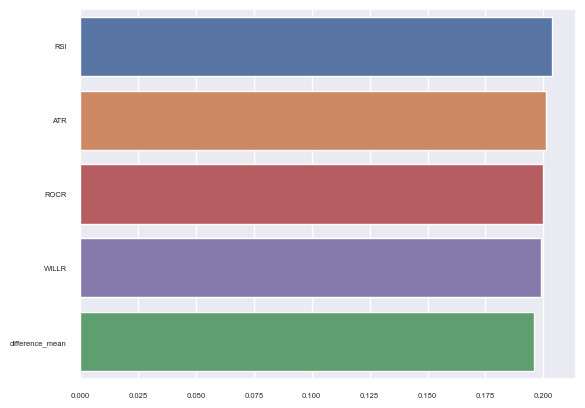

In [34]:
# Assuming `features` is a list of your feature names and each model in `models` is a fitted model
feature_importances = pd.DataFrame({"ET": models["ET"].feature_importances_ }, index=features)

# Convert the DataFrame to have features as columns and models as rows
feature_importances = feature_importances.T

# Now you can sort the mean feature importances for each feature across models
sorted_features = feature_importances.mean().sort_values(ascending=False).index.tolist()

sns.barplot(data=feature_importances, orient='h', order=sorted_features)

- Coefficient (coef): Indicates the direction and magnitude of the effect of each feature on the log-odds of the target variable.
- Standard Error (std err): Measures the variability in the coefficient estimates.
- Z-value (z): The coefficient divided by its standard error, used to test the null hypothesis that the coefficient is zero.
- P-value (P>|z|): Indicates the probability of observing the given result, assuming the null hypothesis is true. A small p-value (typically < 0.05) indicates that you can reject the null hypothesis.

### 6- Perform Hyperparameter Tuning on the Best Model

To perform hyperparameter tuning, we are going to define set of parameters and RandomizedSearchCV will look for the best combination with cross validation.

In [846]:
from sklearn.metrics import make_scorer

def custom_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Check if both class accuracies are above 51%
    if class_accuracies[0] > 0.51 and class_accuracies[1] > 0.51:
        return accuracy_score(y_true, y_pred)  # Return overall accuracy if condition is met
    else:
        return 0  # Return 0 if the condition is not met

# Create the custom scorer
custom_scorer = make_scorer(custom_accuracy)

In [847]:
# Define the hyperparameter grid for Logistic Regression
hyperparameter_grid = {
    'logistic__penalty': ['l2'],  # Regularization penalty
    'logistic__C': [1/4, 1/2, 1, 2/3, 3/4],  # Inverse of regularization strength
    'logistic__solver': ['liblinear'],  # Solvers 'saga'
    'logistic__max_iter': [50, 80, 100, 200, 300, 00]   # Maximum number of iterations
}

# Set up the pipeline
pipeline = Pipeline([
    ('logistic', LogisticRegression(random_state=42))
])

# Randomized search with cross-validation
grid_search  = GridSearchCV(
    estimator=pipeline,
    param_grid=hyperparameter_grid,
    cv=5,  # Cross-validation splitting strategy
    scoring=custom_scorer,  # Scoring metric
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [848]:
param_grid = {
    'xgb__max_depth': [3, 5],
    'knn__kneighborsclassifier__n_neighbors': [3, 5, 7],
    'knn__kneighborsclassifier__weights': ['uniform', 'distance'],
    'gbc__learning_rate': [0.01, 0.1, 0.2],
    'final_estimator__C': [ 1.0, 10.0]
}

grid_search = GridSearchCV(estimator=stacking_clf, param_grid=param_grid, cv=2, n_jobs=-1, scoring='accuracy')


In [849]:
# Fit the random search model
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

ValueError: Invalid parameter 'knn' for estimator StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lear...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=400, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('et', ExtraTreesClassifier(random_state=42)),
                               ('gbc',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression()). Valid parameters are: ['cv', 'estimators', 'final_estimator', 'n_jobs', 'passthrough', 'stack_method', 'verbose'].

### 7 - Best Model Testing

Also On Simulated Data ?

### Final Test with Tuned Hyperparameter 

Accuracy: 0.5448
Accuracy for class 0: 0.5225
Accuracy for class 1: 0.5676
Confusion Matrix:
[[2297 2099]
 [1857 2438]]


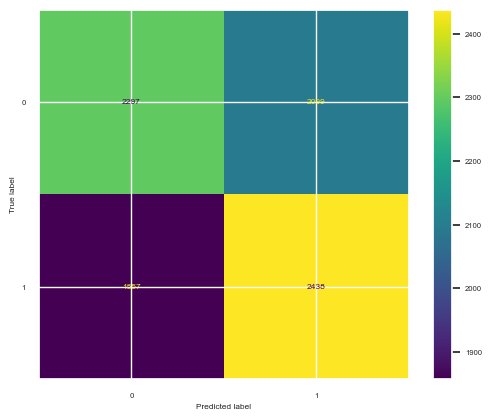

In [35]:
# Predict on the test set using the best estimator

# Predict on validation data
best_model = stacking_clf
train_and_evaluate_model(best_model, X_train, X_test, y_train, y_test, plot=True)


### 9- Walk Forward Validation ?

In [154]:
X_train_rolling = X_train.copy()
y_train_rolling = y_train.copy()
actu_directions = []
pred_directions = []
predictions = []

# Assuming 'test' is your test set, use X_test and y_test for consistency
for t in range(len(X_test)):
    model = best_model
    model_fit = model.fit(X_train_rolling, y_train_rolling)  # Fit model on expanding window

    # Expanding training set with the new observation
    new_X = X_test.iloc[t:t+1]  # Ensure DataFrame format by slicing
    y_pred = model.predict(new_X)  # Ensure new_X has correct column names and order
    predictions.append(y_pred[0])

    X_train_rolling = pd.concat([X_train_rolling, new_X], ignore_index=True)
    y_train_rolling = pd.concat([y_train_rolling, pd.Series([y_test.iloc[t]], index=[X_train_rolling.index[-1]])])

    pred_direction = predictions[-1]
    actu_direction = y_test.iloc[t]
        
    pred_directions.append(pred_direction)
    actu_directions.append(actu_direction)

    print(f'Direction - predicted={pred_direction}, actual={actu_direction}')




Direction - predicted=1.0, actual=1.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=1.0
Direction - predicted=1.0, actual=1.0
Direction - predicted=1.0, actual=1.0
Direction - predicted=1.0, actual=1.0
Direction - predicted=1.0, actual=1.0
Direction - predicted=1.0, actual=0.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=0.0
Direction - predicted=1.0, actual=1.0
Direction - predicted=1.0, actual=1.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=2.0
Direction - predicted=1.0, actual=0.0
Direction - predicted=1.0, actual=1.0
Direction - predicted=1.0, actual=0.0
Direction - predicted=1.0, actual=0.0
Direction - 

KeyboardInterrupt: 

In [853]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, predictions)

# Calcul de l'accuracy par classe
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Affichage de l'accuracy pour chaque classe
for i, class_label in enumerate(model.classes_):
    print(f"Accuracy for class {class_label}: {class_accuracies[i]:.2f}")

print("Confusion Matrix:")
print(cm)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Génération du rapport de classification
report = classification_report(y_test, predictions, target_names=[str(cls) for cls in model.classes_])
print(report)

NameError: name 'predictions' is not defined

### 10 - Save Best Model

In [850]:
import joblib

# Save the trained model to a file
joblib.dump(stacking_clf, 'C:/Users/SolalDanan/Trading Signal/stacking_model.joblib')


['C:/Users/SolalDanan/Trading Signal/stacking_model.joblib']

In [851]:
model = joblib.load('C:/Users/SolalDanan/Trading Signal/stacking_model.joblib')
model

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lear...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=400, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('et', ExtraTreesClassifier(random_state=42)),
                               ('gbc',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression())